Diego Toribio  
Professor Eilin Perez  
SS-322: History and Visuality  
Final Project

In [61]:
import ee
import geemap
from IPython.display import Image

# Authenticate & initialize
ee.Authenticate()
ee.Initialize(project='toribiodiego-ece471')

### Load & Display Monterrey Boundary

Here we load the geoBoundaries ADM2 collection, filter to Monterrey, and display it on a map centered slightly south of the city.

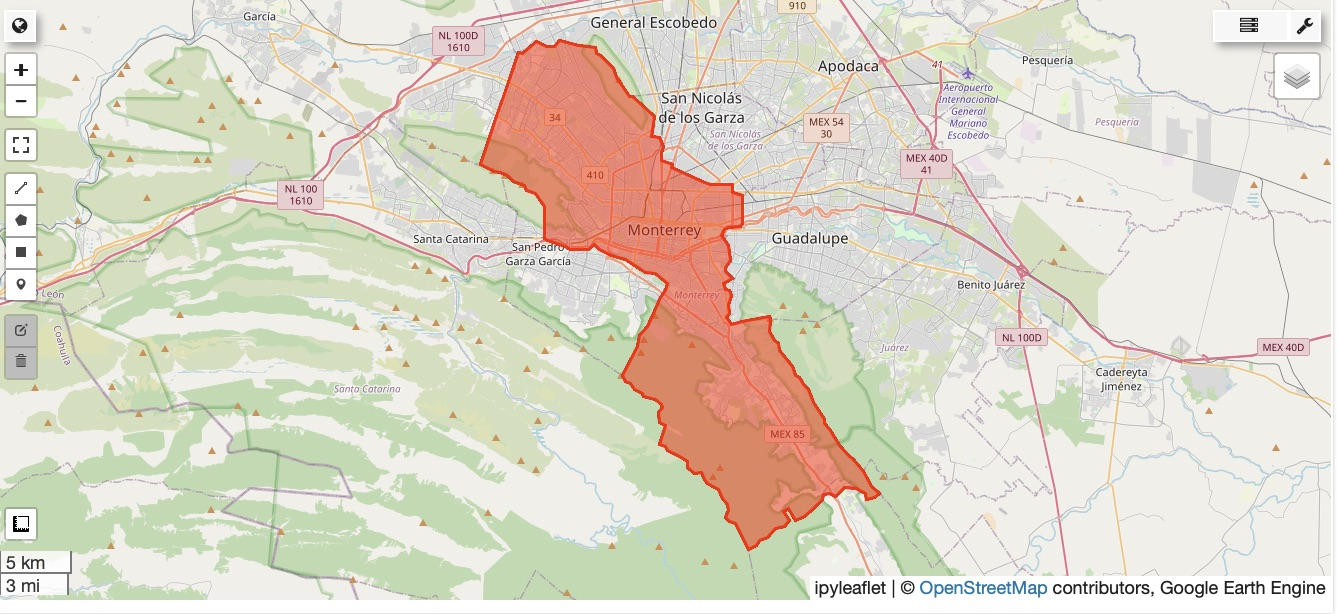

In [33]:
# Load and filter geoBoundaries to Monterrey
geob2 = ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
monterrey_geob = geob2.filter(ee.Filter.And(
    ee.Filter.eq('shapeGroup', 'MEX'),
    ee.Filter.eq('shapeName', 'Monterrey')
))

# Center map slightly south of original coordinates
lat, lon = 25.6866, -100.3161
m = geemap.Map(center=[lat - 0.05, lon], zoom=11)

# Add only the red boundary layer
m.addLayer(
    monterrey_geob,
    {'color': 'red', 'fillColor': '00000000', 'width': 3},
    'geoBoundaries ADM2'
)
m.addLayerControl()
m


Image(filename='boundary.jpeg')

### ΔNDBI Growth Map

We calculate the Normalized Difference Built-up Index (NDBI) for two years (2003 and 2013) using the appropriate Landsat collection and bands, then subtract to get ΔNDBI. Masking out values below 0.05 highlights significant built-up expansion. Finally, we overlay this growth layer on the Monterrey municipal outline for spatial context.

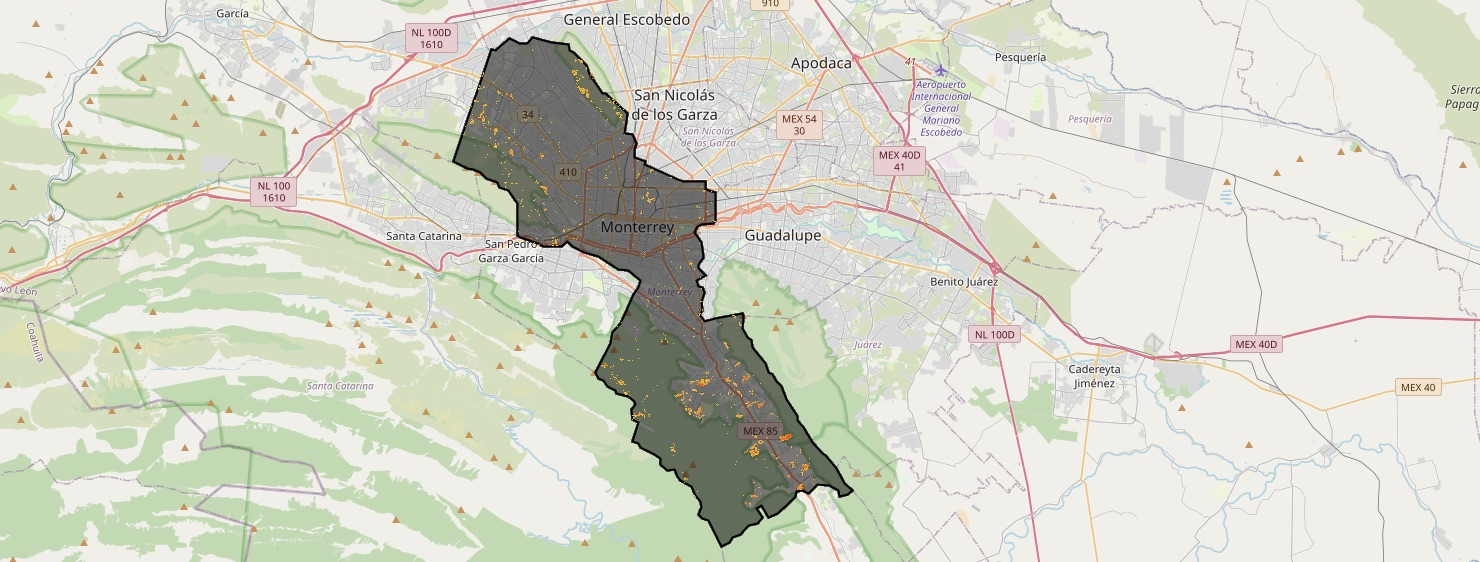

In [38]:
# load and filter Monterrey boundary
boundary_fc = (
    ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
      .filter(ee.Filter.And(
          ee.Filter.eq('shapeGroup', 'MEX'),
          ee.Filter.eq('shapeName', 'Monterrey')
      ))
)

# compute annual NDBI
def ndbi_year(year):
    coll = 'LANDSAT/LE07/C02/T1_L2' if year < 2013 else 'LANDSAT/LC08/C02/T1_L2'
    nir, swir = ('SR_B4','SR_B5') if year < 2013 else ('SR_B5','SR_B6')
    return (
        ee.ImageCollection(coll)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(boundary_fc.geometry())
          .median()
          .clip(boundary_fc.geometry())
          .normalizedDifference([swir, nir])
          .rename('NDBI')
    )

ndbi03 = ndbi_year(2003)
ndbi13 = ndbi_year(2013)
growth = ndbi13.subtract(ndbi03).rename('ΔNDBI')

# visualization parameters
vis_growth = {
    'min': 0,
    'max': 0.3,
    'palette': ['#f0ff1e', '#f78d08', '#f71d06', '#110cff']
}

# display outline and growth
m = geemap.Map(center=[25.635, -100.3161], zoom=11)
m.addLayer(
    boundary_fc,
    {'color': 'black', 'fillColor': '#00000000', 'width': 2, 'fillOpacity': 0},
    'Monterrey Outline'
)
m.addLayer(
    growth.updateMask(growth.gt(0.05)),
    vis_growth,
    'Growth 2003 → 2013'
)
m.addLayerControl()
m

Image(filename='growth_map.jpeg')

### 5-Year ΔNDBI GIF

Compute ΔNDBI over 5-year steps, blend with the Monterrey outline, and render as an animated GIF.


In [63]:

def compute_ndbi_year(boundary_fc, year):
    """Return the median‐composite NDBI image for a given year over boundary_fc."""
    if year < 2013:
        coll_id, nir, swir = 'LANDSAT/LE07/C02/T1_L2', 'SR_B4', 'SR_B5'
    else:
        coll_id, nir, swir = 'LANDSAT/LC08/C02/T1_L2', 'SR_B5', 'SR_B6'
    img = (ee.ImageCollection(coll_id)
           .filterDate(f'{year}-01-01', f'{year}-12-31')
           .filterBounds(boundary_fc.geometry())
           .median()
           .clip(boundary_fc.geometry()))
    return img.normalizedDifference([swir, nir]).rename('NDBI')


def compute_growth_frames(boundary_fc,
                          start_year, end_year,
                          interval=5,
                          threshold=0.05,
                          vis_params=None,
                          boundary_color='ffffff',
                          boundary_width=2):
    """
    Compute a list of RGB frames showing ΔNDBI over each interval.
    Returns: list of ee.Image, each with its system:time_start property.
    """
    if vis_params is None:
        vis_params = {
            'min': 0, 'max': 0.3,
            'palette': ['#f0ff1e','#f78d08','#f71d06','#110cff']
        }

    # Rasterize the white boundary once
    boundary_img = ee.Image().byte().paint(boundary_fc, 1, boundary_width)
    boundary_rgb = boundary_img.visualize(
        palette=[boundary_color], forceRgbOutput=True
    )

    years = list(range(start_year, end_year + 1, interval))
    frames = []

    for s in years[:-1]:
        e = s + interval
        # Compute NDBI for start and end
        ndbi_start = compute_ndbi_year(boundary_fc, s)
        ndbi_end   = compute_ndbi_year(boundary_fc, e)

        # Difference and mask
        diff = ndbi_end.subtract(ndbi_start).rename('ΔNDBI')
        mask = diff.gt(threshold)             # ee.Image mask
        diff = diff.updateMask(mask)          # apply mask

        # Tag timestamp
        diff = diff.set('system:time_start',
                        ee.Date.fromYMD(e, 1, 1).millis())

        # Visualize & blend with boundary
        growth_rgb = diff.visualize(**vis_params)
        frame = growth_rgb.blend(boundary_rgb) \
                          .set('system:time_start', diff.get('system:time_start'))
        frames.append(frame)

    return frames


def make_gif_url(frames, region, fps=1, dimensions=600):
    """
    Turn a list of pre-rendered RGB frames into a hosted GIF URL.
    """
    ic = ee.ImageCollection(frames)
    gif_args = {
        'framesPerSecond': fps,
        'dimensions':     dimensions,
        'region':         region,
        'format':         'gif'
    }
    return ic.getVideoThumbURL(gif_args)


boundary_fc = (ee.FeatureCollection('WM/geoLab/geoBoundaries/600/ADM2')
               .filter(ee.Filter.And(
                   ee.Filter.eq('shapeGroup','MEX'),
                   ee.Filter.eq('shapeName','Monterrey')
               )))

frames = compute_growth_frames(
    boundary_fc=boundary_fc,
    start_year=2000,
    end_year=2025,
    interval=5,
    threshold=0.05
)

gif_url = make_gif_url(frames, boundary_fc.geometry())

HTML(f'''
<div style="text-align:center; margin-top:20px;">
  <h3>Urban Growth (ΔNDBI) every 5 years</h3>
  <img src="{gif_url}"
       style="max-width:600px; width:100%; height:auto;"
       alt="ΔNDBI GIF"/>
</div>
''')